In [1]:
# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"1"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Hypothesis Testing Circuits

The primary tests we want to replicate are the faithfulness test (Equiavelance) and the minimality test (Minimality)

Faithfulness Test
- the full model and ablated model are equally likely to outpeform each other on a task
    - probability of the delta of the score function is greater then 0 - 1/2 is less than epsilon
    - use a sign test
    - test statistic is the # of times C* and M outperform each other 
    - test statistic is absolue value of the difference between the mean that the ablated model outpeforms the original model and 1/2
- P value (value of test statistic such that P(T > T_obs) = alpha) given by binomial distribution P(K > (T_obs + 1/2) * n | \theta = (1/2) + \epsilon)
    how do we choose epsilon?
    set to 0.1



# Minimal Faithful Circuit According to Attribution Score Ordering

In [2]:
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from transformer_lens import HookedTransformer

from auto_circuit.types import (
    CircuitOutputs, 
    BatchKey,
    PruneScores,
    PatchType, 
    AblationType,
    SrcNode, 
    DestNode, 
    Edge,
    Node
)
from auto_circuit.data import PromptPairBatch, PromptDataLoader   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.tasks import (
    Task,
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK,
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_TOKEN_CIRCUIT_TASK,
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK,
    GREATERTHAN_COMPONENT_CIRCUIT_TASK,  
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    CAPITAL_CITIES_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    TRACR_REVERSE_TOKEN_CIRCUIT_TASK,
    docstring_true_edges
)
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.tensor_ops import batch_answer_diffs, batch_avg_answer_val
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.custom_tqdm import tqdm

from elk_experiments.auto_circuit.auto_circuit_utils import (
    run_circuits,
    desc_prune_scores, 
    prune_scores_threshold, 
    load_tf_model
)
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc, get_score_func

from elk_experiments.auto_circuit.circuit_hypotests import (
    get_edge_idx, 
    edges_from_mask,
    equiv_test,
    sweep_search_smallest_equiv,
    plot_num_ablated_C_gt_M, 
    plot_circuit_and_model_scores,
    compute_knees, 
    plot_edge_scores_and_knees,
    minimality_test, 
    plot_p_values, 
    plot_edge_k, 
    plot_score_quantiles,
    independence_test
)

from elk_experiments.auto_circuit.node_graph import (
    NodeGraph, 
    SeqNode, 
    NodeIdx,
    SampleType,
    get_node_idx, 
    sample_paths, 
    visualize_graph, 
)

In [3]:

DOCSTRING_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK: Task = Task(
    key="Docstring Component Circuit",
    name="Docstring",
    _model_def="pythia-70m-deduped",
    _dataset_name="docstring_prompts",
    batch_size=2,
    batch_count=128,
    _true_edge_func=None,
    token_circuit=False,
    autoencoder_input="resid_delta_mlp",
    autoencoder_max_latents=200,
    autoencoder_pythia_size="2_32768",
    autoencoder_prune_with_corrupt=False,
)

from auto_circuit.metrics.official_circuits.circuits.ioi_official import (
    ioi_head_based_official_edges,
    ioi_true_edges,
)
IOI_TOKEN_CIRCUIT_TASK: Task = Task(
    key="Indirect Object Identification Token Circuit",
    name="Indirect Object Identification",
    _model_def="gpt2-small",
    _dataset_name="ioi/ioi_vanilla_template_prompts",
    batch_size=(60, 20),
    batch_count=(5, 5),
    _true_edge_func=ioi_head_based_official_edges,
    token_circuit=True,
)

In [4]:
task = DOCSTRING_TOKEN_CIRCUIT_TASK
token = task.token_circuit

task.init_task()

# docstring_task = DOCSTRING_COMPONENT_CIRCUIT_TASK
# ablation_type = AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT
use_abs = False
ablation_type = AblationType.TOKENWISE_MEAN_CORRUPT
clean_corrupt = "corrupt" if ablation_type == AblationType.RESAMPLE else None 
alpha = 0.05
epsilon = 0.1 if use_abs else 0.0
q_star = 0.9
side = None if use_abs else "left"
eg_min_layer = 3 # 21 for IOI
sg_max_layer = 2 # 3 for IOI
grad_function = GradFunc.LOGPROB if not use_abs else GradFunc.LOGIT
answer_function = AnswerFunc.AVG_VAL if not use_abs else AnswerFunc.AVG_DIFF
grad_function_attrib = grad_function
answer_function_attrib = answer_function

Loaded pretrained model attn-only-4l into HookedTransformer
seq_len before divergence 41
seq_len after divergence 30


In [5]:
# compute edge scores
# TODO: pass full model
prune_scores = mask_gradient_prune_scores(
    model=task.model, 
    dataloader=task.train_loader,
    official_edges=None,
    grad_function=grad_function_attrib.value, #grad_function,
    answer_function=answer_function_attrib.value, #answer_function,
    mask_val=None, 
    ablation_type=ablation_type,
    integrated_grad_samples=10, # 10 1 for debugging
    clean_corrupt=clean_corrupt,
)

In [6]:
model_out_train: dict[BatchKey, torch.Tensor] = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.train_loader
}
model_out_test: dict[BatchKey, torch.Tensor] = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.test_loader
}

In [7]:
equiv_results, min_equiv = sweep_search_smallest_equiv(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    grad_function=grad_function, 
    answer_function=answer_function,
    ablation_type=ablation_type,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
    model_out=model_out_train,
)

interval: 0 - 38430
width 1000


interval: 0 - 1000
width 100


interval: 0 - 100
width 10


interval: 20 - 30
width 1


In [8]:
equiv_test_result = equiv_test(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    grad_function=grad_function, 
    answer_function=answer_function,
    ablation_type=ablation_type,
    edge_counts=[min_equiv],
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
    model_out=model_out_test
)
print("Equiv on Test: ", not equiv_test_result[min_equiv].not_equiv)

Equiv on Test:  True


In [10]:
threshold = prune_scores_threshold(prune_scores, min_equiv, use_abs=use_abs)
edge_mask = {k: (torch.abs(v) if use_abs else v) >= threshold for k, v in prune_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, token=task.token_circuit)


In [11]:
# contruct a graph from the pruned circuit, to further prune
node_circ_graph = NodeGraph(edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
node_circ_graph.build_graph()

In [12]:
assert set(node_circ_graph.parents.keys()) == set([k for k in node_circ_graph.children.keys() if k.name != "Resid Start"])

In [13]:
valid_edges = [edge for edge in edges if node_circ_graph.edge_in_path(edge)]
len(valid_edges)

15

In [15]:
# mask out all edges not in edges to dest
valid_edge_scores = deepcopy(prune_scores)
for edge in set(edges) - set(valid_edges):
    edge_idx = get_edge_idx(edge, tokens=task.token_circuit)
    valid_edge_scores[edge.dest.module_name][edge_idx] = 0.0

In [16]:
# from elk_experiments.auto_circuit.circuit_hypotests import equiv_test
# recompute equivalence 
valid_edges_equiv_result = equiv_test(
    task.model, 
    task.train_loader,
    valid_edge_scores,
    grad_function,
    answer_function,
    ablation_type,
    thresholds=[threshold],
    model_out=model_out_train,
    full_model=None,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)[len(valid_edges)]

In [17]:
print(torch.topk(valid_edges_equiv_result.circ_scores - equiv_results[len(edges)].circ_scores, 4))
assert not valid_edges_equiv_result.not_equiv
assert torch.allclose(valid_edges_equiv_result.circ_scores, equiv_results[len(edges)].circ_scores, atol=1e-4)

torch.return_types.topk(
values=tensor([1.8239e-05, 1.8239e-05, 1.4782e-05, 1.4722e-05], device='cuda:0'),
indices=tensor([ 50, 113, 106,  89], device='cuda:0'))


In [18]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=valid_edge_scores,
    score_threshold=threshold,
    show_all_seq_pos=True,
    orientation="h",
    use_abs=False,
    seq_labels=task.test_loader.seq_labels,
)

In [19]:
#TODO: fix to allow for negative epsilon
fig, ax = plot_num_ablated_C_gt_M(equiv_results, epsilon=epsilon, min_equiv=min_equiv, side="left" if not use_abs else None)

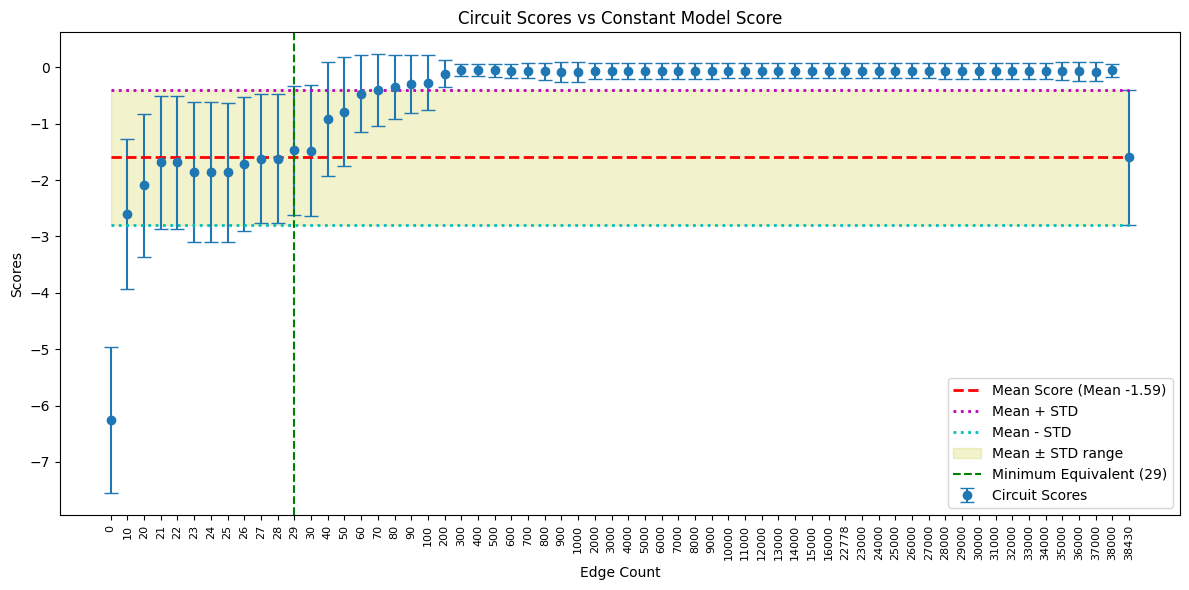

In [20]:
fig, ax = plot_circuit_and_model_scores(equiv_results, min_equiv)

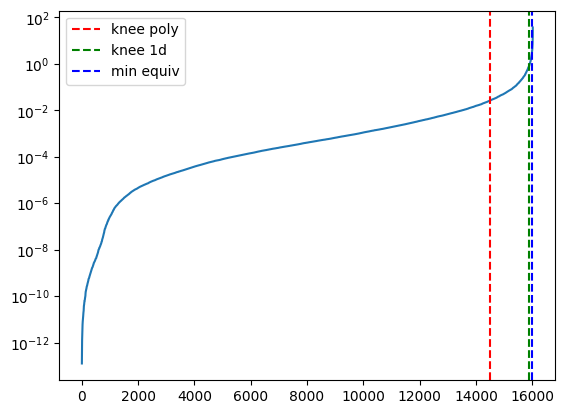

In [21]:
# plot attribution scores 
import numpy as np
edge_scores = np.flip(desc_prune_scores(prune_scores, use_abs=use_abs).detach().cpu().numpy())
if not use_abs:
    edge_scores = edge_scores[edge_scores > 0]
kneedle_poly, kneedle_1d = compute_knees(edge_scores)
fig, ax = plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv)

In [22]:
round(len(edge_scores) - kneedle_poly.knee), round(len(edge_scores) - kneedle_1d.knee), min_equiv

(1533, 126, 29)

# Minimality Test

In the original IOI paper, the minimality test checks if for some subcircuit of the circuit, is a node minimal (I think). I want to ask is the edge under test minimal with respect to all paths it belongs to

(need to think about what a good reference distribution is - I think just doing the same thing for the edge sampled from the complement)

## Minimality Test on Paths of Edges 

In [20]:
# given a circuit and an edge, return edges in path of circuit 
#  propogate forward and backward from edge (could do some kind of dp solution too)
# I guess construct node graph from circuit edges
# dfs from src, dfs from dest,
# get edes in path with dest pairs to edges 
# I guess for each node store all paths (can do this while counting the paths)


# with the current implementation, I think we can do the forward part very quickly, by ...eh no maybe not, still need to dfs/bfs it
# storage costs blow up, probably makes sense to only do it for the subcircuit (or just bite the time costs?)
# I think it will become clearer once the NodGraph object is complete

## Build Graph Used To Sample Paths

In [29]:
node_graph = NodeGraph(task.model.edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
node_graph.build_graph()

In [31]:
end_graph = {k: v for k, v in node_graph.children.items() if k.layer > eg_min_layer}  # 21
end_graph_path_counts = {k: v for k, v in node_graph.path_counts.items() if k.layer > 3}

start_graph = {k: [v for v in vs if v.layer < sg_max_layer] for k, vs in node_graph.children.items() if k.layer < sg_max_layer}
start_graph_path_counts = {k: v for k, v in node_graph.path_counts.items() if k.layer < sg_max_layer}
sum([len(v) for v in end_graph.values()]), sum([len(v) for v in start_graph.values()])

(488, 720)

In [32]:
# end of graph
visualize_graph(end_graph, end_graph_path_counts)

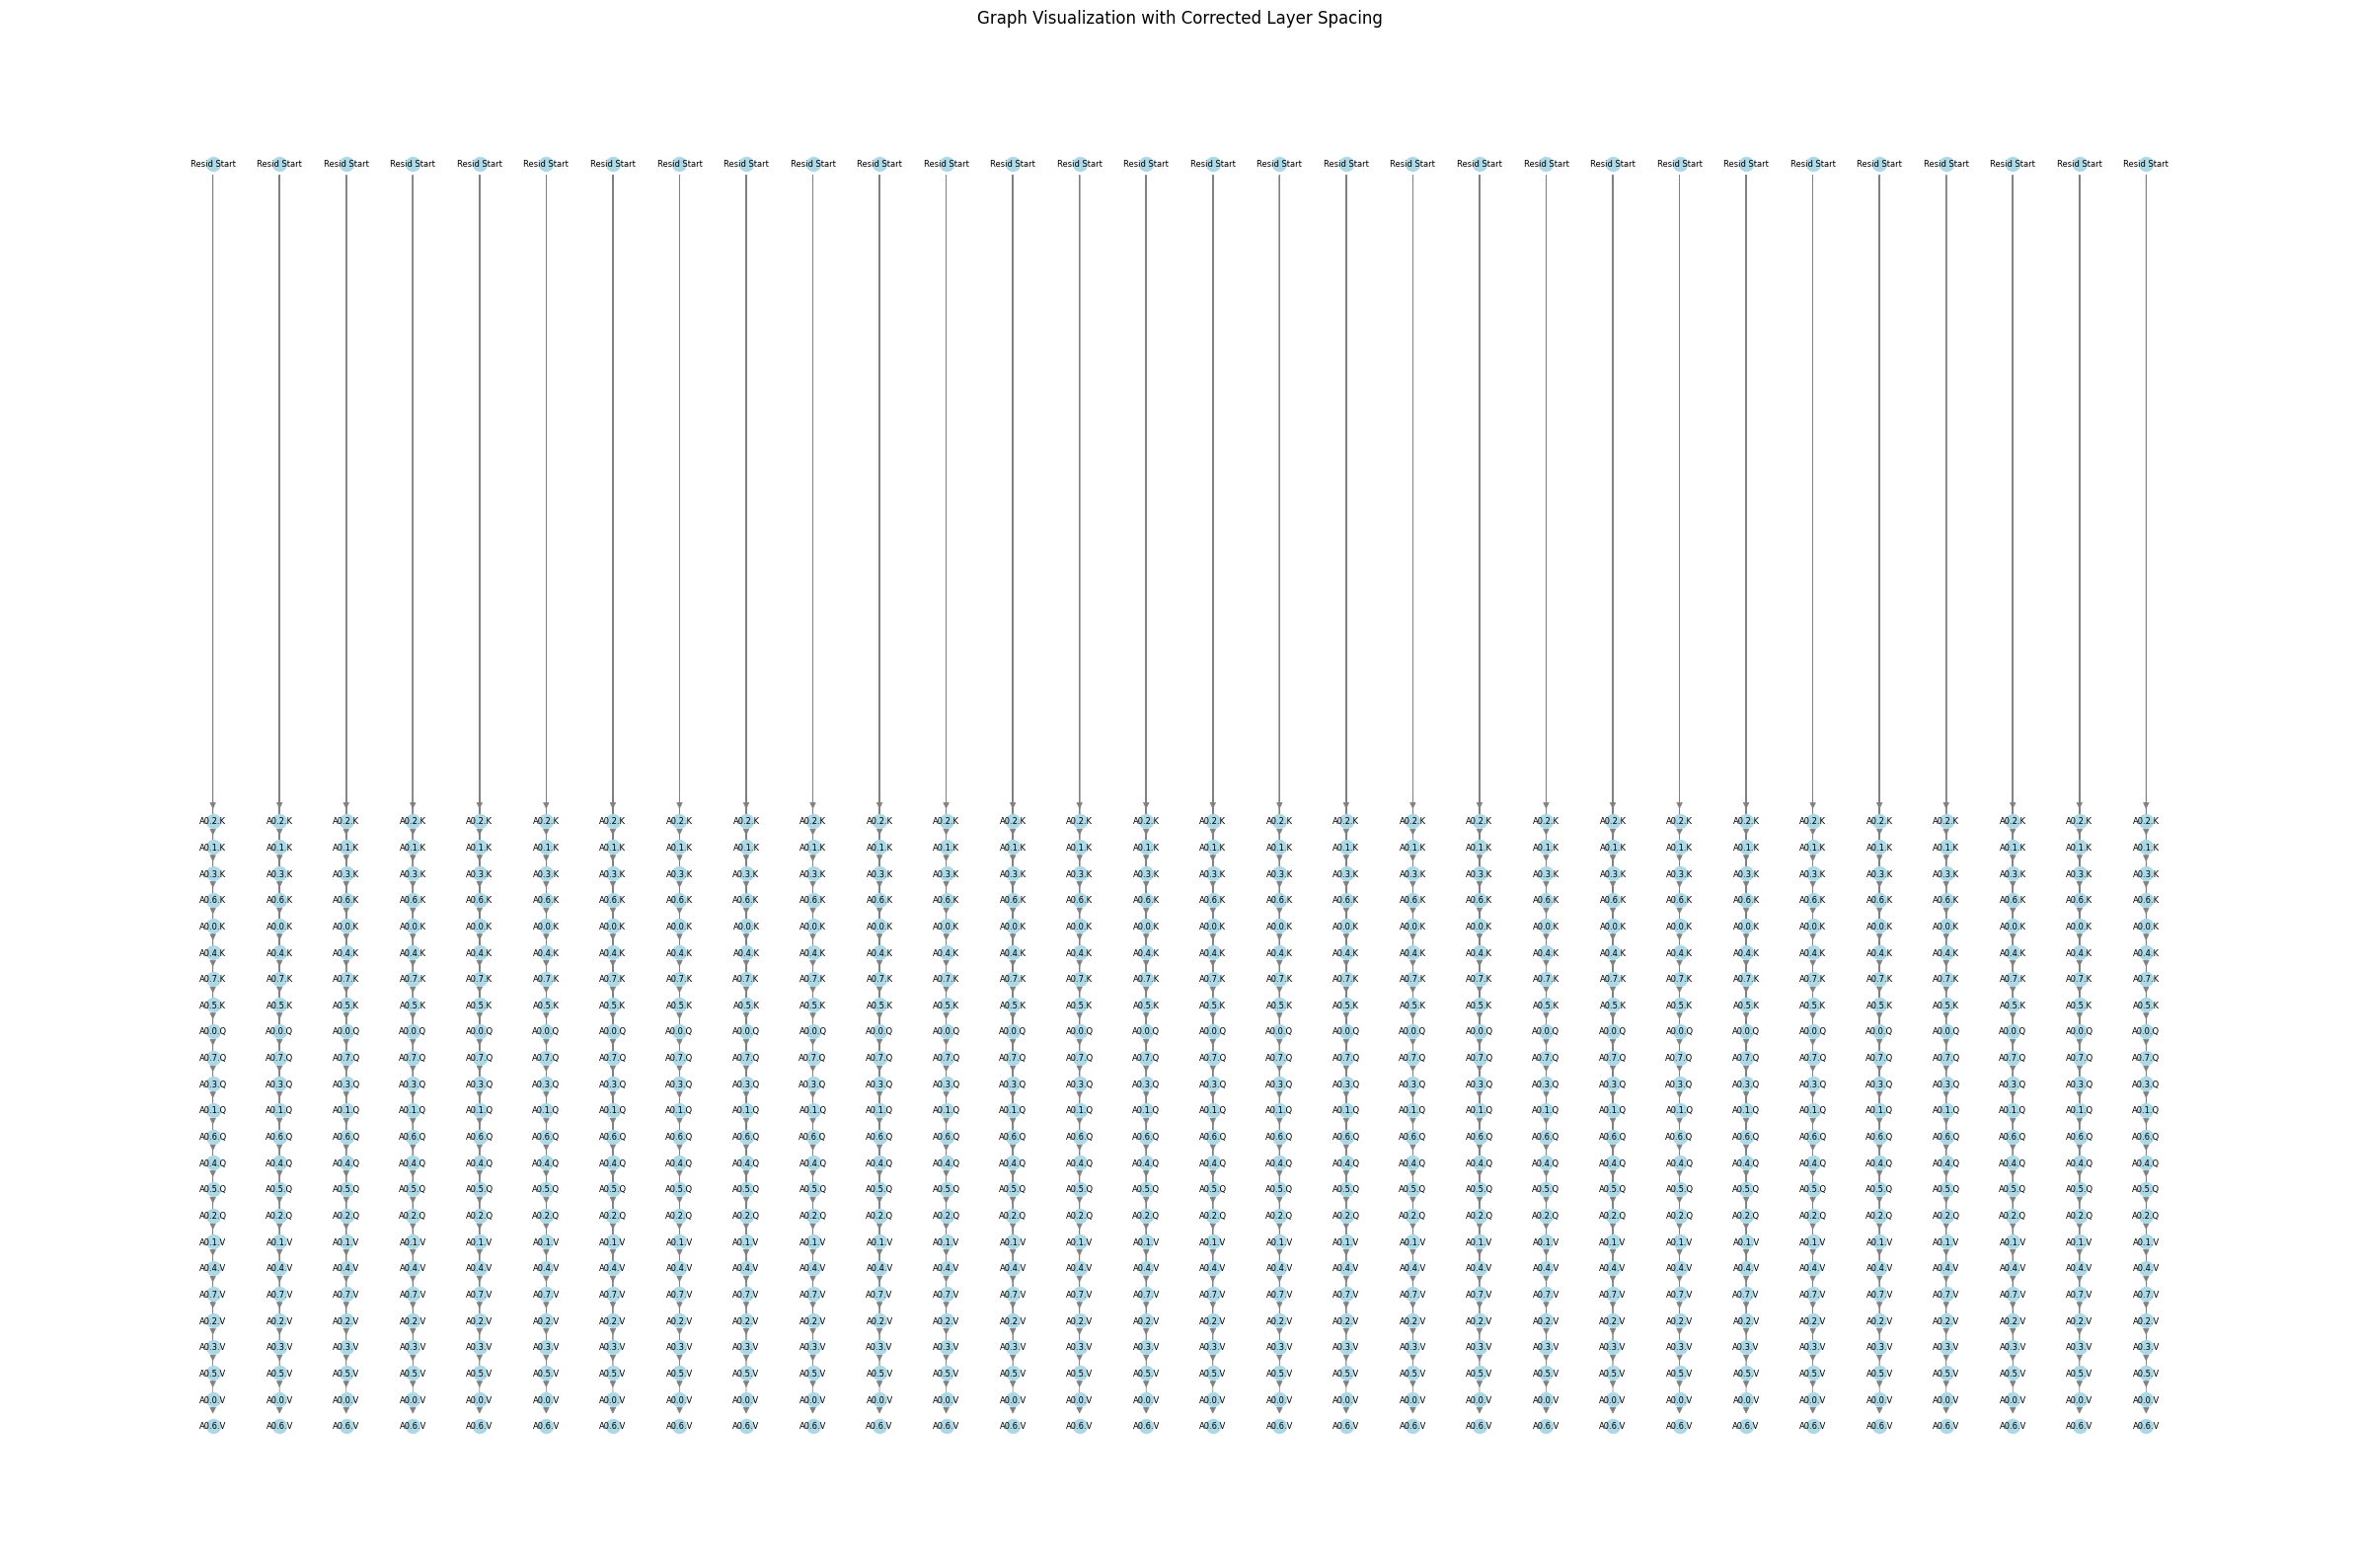

In [33]:
# start of graph
visualize_graph(start_graph, start_graph_path_counts, sort_by_head=False)

## Sample Paths

In [36]:
# sample paths to be used for testing
n_paths = 256 
filtered_paths_walk = sample_paths(node_graph, n_paths, SampleType.WALK, valid_edges)
mean_walk = np.mean([len(path) for path in filtered_paths_walk])
filtered_paths_uniform = sample_paths(node_graph, n_paths, SampleType.UNIFORM, valid_edges)
mean_uniform = np.mean([len(path) for path in filtered_paths_uniform])
mean_walk, mean_uniform

(np.float64(3.25390625), np.float64(4.95703125))

In [37]:
edge_scores = {edge: valid_edge_scores[edge.dest.module_name][get_edge_idx(edge, tokens=task.token_circuit)] for edge in valid_edges}
tested_edges = sorted(edge_scores.keys(), key=lambda x: abs(edge_scores[x]), reverse=False)

## Run Minimality Tests

In [41]:
min_test_results = minimality_test(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=valid_edge_scores,
    edges=tested_edges, 
    edge_count=len(valid_edges),
    ablation_type=ablation_type,
    grad_function=grad_function,
    answer_function=answer_function,
    filtered_paths=filtered_paths_walk,
    use_abs=use_abs,
    tokens=task.token_circuit,
    alpha=alpha, 
    q_star=q_star
)

In [46]:
# minimality test on true edges
true_edge_prune_scores = {mod_name: torch.zeros_like(score_func) for mod_name, score_func in prune_scores.items()}
for edge in task.true_edges:
    true_edge_prune_scores[edge.dest.module_name][get_edge_idx(edge, tokens=task.token_circuit)] = 1.0

filtered_paths_true_edge = sample_paths(node_graph, n_paths, SampleType.WALK, task.true_edges)
min_test_true_edge_results = minimality_test(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=true_edge_prune_scores,
    edges=task.true_edges, 
    edge_count=task.true_edge_count,
    ablation_type=ablation_type,
    grad_function=grad_function,
    answer_function=answer_function,
    filtered_paths=filtered_paths_true_edge,
    use_abs=use_abs,
    tokens=task.token_circuit,
    alpha=alpha, 
    q_star=q_star,
    stop_if_failed=True
)

KeyboardInterrupt: 

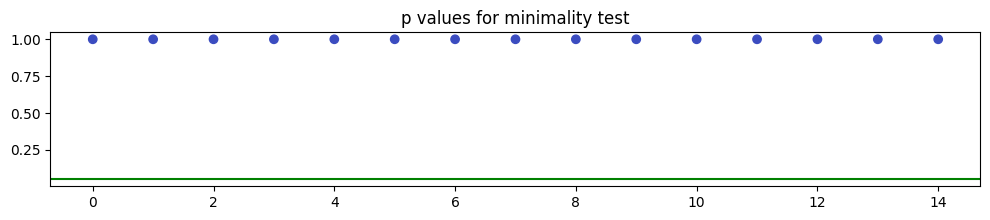

In [47]:
# plot p values as scatter plot
#TODO: I think there's an error here? 
fig, ax = plot_p_values(min_test_results, tested_edges, edge_scores)


In [48]:
true_edge_scores = {edge: torch.tensor(1.1) for edge in task.true_edges}
fig, ax = plot_p_values(min_test_true_edge_results, task.true_edges, true_edge_scores)

NameError: name 'min_test_true_edge_results' is not defined

In [49]:
# plot frac of n 
batch_size = task.batch_size[1] if isinstance(task.batch_size, tuple) else task.batch_size
batch_count = task.batch_count[1] if isinstance(task.batch_count, tuple) else task.batch_count
plot_edge_k(min_test_results, tested_edges, edge_scores, batch_size * batch_count, q_star=q_star)


(<Figure size 1200x200 with 1 Axes>,
 <Axes: title={'center': 'k for minimality test'}>)

In [50]:
batch_size = task.batch_size[1] if isinstance(task.batch_size, tuple) else task.batch_size
batch_count = task.batch_count[1] if isinstance(task.batch_count, tuple) else task.batch_count
plot_edge_k(min_test_true_edge_results, task.true_edges, true_edge_scores, batch_size * batch_count, q_star=q_star)

NameError: name 'min_test_true_edge_results' is not defined

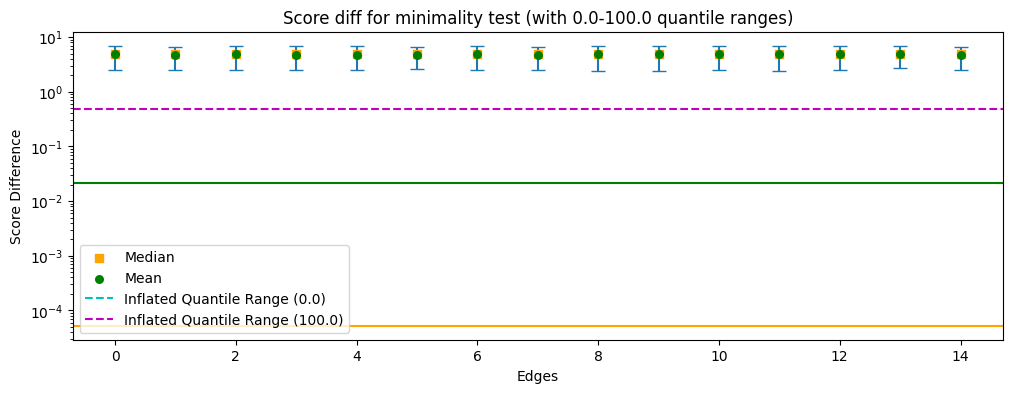

In [51]:
# plot average diff 
fit, ax = plot_score_quantiles(min_test_results, tested_edges, edge_scores, quantile_range=[0.00, 1.00])


In [52]:
fit, ax = plot_score_quantiles(min_test_true_edge_results, task.true_edges, true_edge_scores, quantile_range=[0.00, 1.00])

NameError: name 'min_test_true_edge_results' is not defined

## Independence Test
Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

Null Hypothesis: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 


Ok background 

see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/

Hilbert-Schmidt Norm is just the Frobenious (L2) norm on matricies

Inner Product of Cross Covariance Matrix with itself is the same as the inner product of the auto-covariance matricies

So then we can apply separate kernel functions to the X's and Y's, compute the auto-covariance matrices, and then compute the squared inner 
product of the kernelized covariance matricies

...but there's some nuance in how you compute the covariance matricies from the kernelized data 
in particular we're assuming the kernel function has mean 0
- just remember to center it

still don't fully understand kernels/hilbert spaces


ok so the hypothesis paper defines it as the trace of K_{x,y}K_{x,y}, but can also define it as {K_x}{K_y}, b/c that holds in general for Cross Covariance and Auto Covariance 

Ok I'm confused why we would expect changing the order of Y to effect things...

intuition is that the trace gets the squared terms of correlations on the matching samples, so if there's correlation those should be larger than other permuations

so, if the null is that they're independent, we should expect a larger number of the permutations to be larger then the original ordering. If they are correlated, then 
fewer of the perumations should be greater, our p-value will be smaller, and thus we're more likely to reject the null



what value of $\rho$ do they use? maybe its just gaussian kernel?
"median pairwise distance betwen two samples




In [ ]:
# TODO: factor independence test into code, then run on ground truth
# then run on synthetic circuits
# after that, I think we should be good to set up the sweep experiment infrastructure

In [55]:
indep_result = independence_test(
    model=task.model, 
    dataloader=task.test_loader, 
    prune_scores=valid_edge_scores, 
    grad_function=grad_function,
    answer_function=answer_function,
    threshold=threshold, 
    use_abs=use_abs,
    B=1000
)
indep_result

IndepResults(not_indep=np.False_, p_value=np.float64(0.147))

In [60]:
indep_true_edge_result = independence_test(
    task.model, 
    task.test_loader, 
    true_edge_prune_scores, 
    grad_function=grad_function,
    answer_function=answer_function,
    threshold=0.9, 
    use_abs=True,
    alpha=alpha,
    B=1000
)
indep_true_edge_result

IndepResults(not_indep=np.True_, p_value=np.float64(0.0))